# Encrypted Traffic Analysis: Fingerprinting Audio Streaming Quality

## 1. Project Overview & Methodology
The objective of this project is to determine if encrypted network traffic patterns can reveal the audio quality setting of a streaming session without inspecting the payload. Modern streaming services like Spotify and SoundCloud encrypt data using TLS/SSL, preventing direct analysis of the content. However, side-channel information—specifically packet timing, volume, and throughput—may leak information regarding the playback bitrate.

### Data Acquisition
Data was collected using an automated Python framework combining `Selenium` for browser control and `Scapy` for packet sniffing. To ensure data purity:
* **Spotify:** Data was collected from two distinct accounts: one "Free" tier (approx. 160kbps with ads) and one "Premium" tier (approx. 320kbps). The browser cache was surgically cleared via Chrome DevTools Protocol (CDP) before every capture to force a fresh network fetch.
* **SoundCloud:** Data was collected by toggling the platform's streaming quality settings between "Standard" and "High Quality" (Go+).
* **Sampling:** Each capture session lasted 15 seconds, targeting the initial buffering phase where data throughput is highest.

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configuration: Define paths to the dataset directories
BASE_DIR = Path("final_dataset")
FREE_DIR = BASE_DIR / "free_playlist"
PREMIUM_DIR = BASE_DIR / "premium_playlist"
SC_LOW_DIR = BASE_DIR / "soundcloud_low"
SC_HIGH_DIR = BASE_DIR / "soundcloud_high"

## 2. Feature Engineering
Raw network packets must be converted into statistical features suitable for machine learning. The `extract_features` function aggregates individual packet metadata into session-level statistics. The hypothesis is that higher bitrate streams will exhibit higher throughput and distinct packet inter-arrival times (jitter).

Key features extracted include:
* **Throughput (kbps):** The primary indicator of quality. Calculated as `(Total Bytes * 8) / Duration`.
* **Packet Count:** The total number of packets received during the 15-second window.
* **Inter-Arrival Time (IAT):** The average time delta between consecutive packets, useful for detecting "bursty" buffering behavior.

### Experiment A: Spotify Quality Detection
In this control experiment, a Random Forest classifier was trained on the Spotify dataset. The data was split into training (80%) and testing (20%) sets. Because Spotify Premium utilizes a significantly higher bitrate codec (Ogg Vorbis 320kbps) compared to the Free tier (AAC 160kbps), we expect high separability between classes.

Loading Data...
   Found 100 Free samples
   Found 100 Premium samples

Total Valid Samples: 200

Average Stats per Class:
            throughput_kbps  packet_count  total_bytes
label_name                                            
Free             236.562422        411.76    401435.37
Premium          533.656413        814.30    902103.56

Training Model...

Model Accuracy: 97.50%

Classification Report:
              precision    recall  f1-score   support

        Free       0.95      1.00      0.98        21
     Premium       1.00      0.95      0.97        19

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



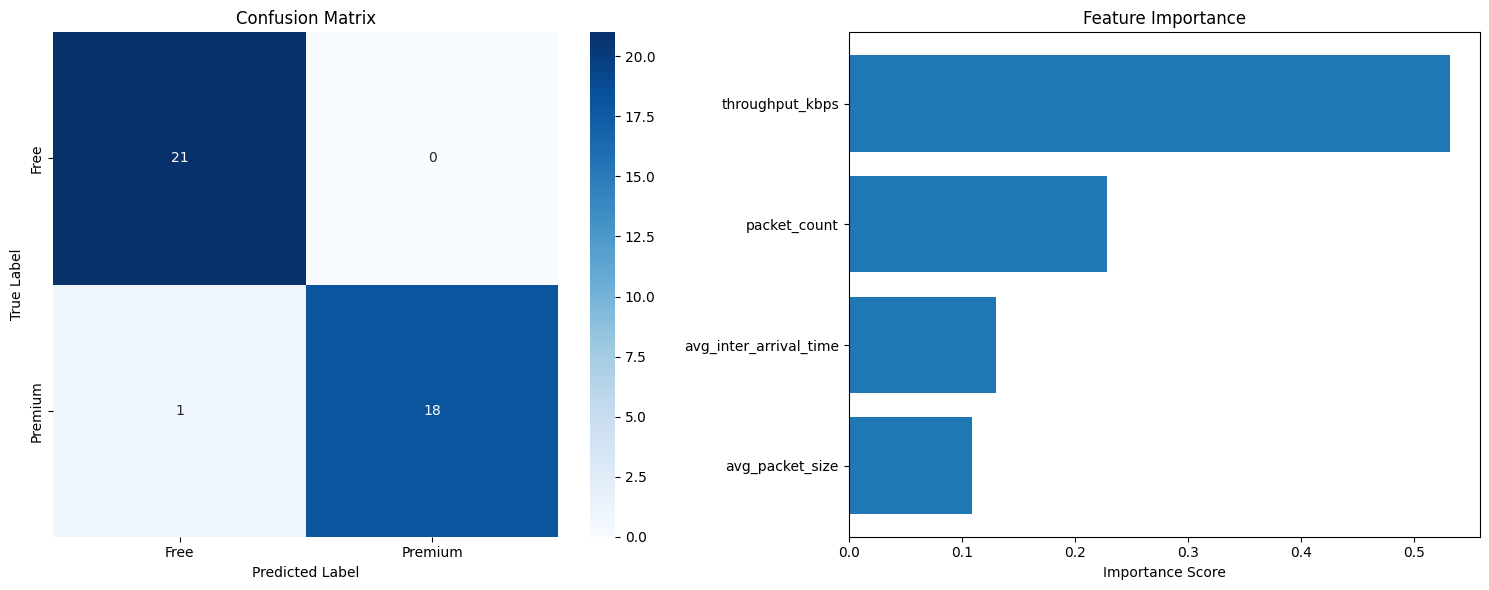

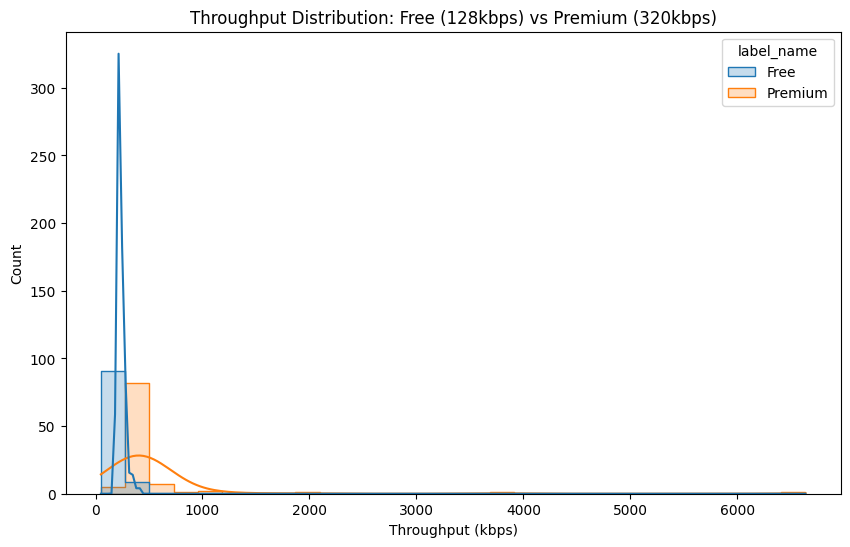

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- CONFIGURATION ---
# Define paths to your data
BASE_DIR = Path("final_dataset")
FREE_DIR = BASE_DIR / "free_playlist"
PREMIUM_DIR = BASE_DIR / "premium_playlist"

def load_session(file_path):
    """Loads a single pickle file."""
    try:
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Error reading {file_path.name}: {e}")
        return None

def extract_features(packets):
    """
    Converts a list of packets into ML features.
    
    Key Logic:
    - Spotify Premium (320kbps) sends MORE bytes per second than Free (128kbps).
    - We calculate 'Throughput' to capture this.
    """
    if not packets or len(packets) < 10:
        return None
        
    # Convert to DataFrame for easier stats
    df = pd.DataFrame(packets)
    
    # 1. Time duration of the capture
    start_time = df['ts'].min()
    end_time = df['ts'].max()
    duration = end_time - start_time
    
    # Avoid division by zero
    if duration <= 0:
        duration = 1.0
        
    # 2. Total Data Volume
    total_bytes = df['len'].sum()
    packet_count = len(df)
    
    # 3. Throughput (The "Smoking Gun" Feature)
    # Convert Bytes -> Bits (x8)
    bits_per_sec = (total_bytes * 8) / duration
    
    # 4. Packet Statistics
    avg_packet_size = df['len'].mean()
    std_packet_size = df['len'].std()
    
    # 5. Inter-arrival Times (Jitter)
    # How much time passes between packets?
    # High quality streams often have "burstier" traffic.
    df = df.sort_values('ts')
    inter_arrival_times = df['ts'].diff().dropna()
    avg_iat = inter_arrival_times.mean()
    
    return {
        'throughput_kbps': bits_per_sec / 1000, # Kilobits per second
        'packet_count': packet_count,
        'total_bytes': total_bytes,
        'avg_packet_size': avg_packet_size,
        'std_packet_size': std_packet_size,
        'avg_inter_arrival_time': avg_iat,
        'duration': duration
    }

# --- MAIN EXECUTION ---
print("Loading Data...")
data_list = []

# 1. Load FREE Data (Label = 0)
if FREE_DIR.exists():
    files = list(FREE_DIR.glob("*.pkl"))
    print(f"   Found {len(files)} Free samples")
    for f in files:
        pkts = load_session(f)
        feats = extract_features(pkts)
        if feats:
            feats['label'] = 0
            feats['label_name'] = 'Free'
            data_list.append(feats)
else:
    print("Free directory not found!")

# 2. Load PREMIUM Data (Label = 1)
if PREMIUM_DIR.exists():
    files = list(PREMIUM_DIR.glob("*.pkl"))
    print(f"   Found {len(files)} Premium samples")
    for f in files:
        pkts = load_session(f)
        feats = extract_features(pkts)
        if feats:
            feats['label'] = 1
            feats['label_name'] = 'Premium'
            data_list.append(feats)
else:
    print("Premium directory not found!")

# Convert to DataFrame
df = pd.DataFrame(data_list)

# 3. Check for Data Quality
print(f"\nTotal Valid Samples: {len(df)}")
if df.empty:
    raise ValueError("No data loaded! Check your paths.")

print("\nAverage Stats per Class:")
print(df.groupby('label_name')[['throughput_kbps', 'packet_count', 'total_bytes']].mean())

# --- TRAIN MODEL ---
print("\nTraining Model...")

# Features to use (X) and Target (y)
feature_cols = ['throughput_kbps', 'packet_count', 'avg_packet_size', 'avg_inter_arrival_time']
X = df[feature_cols]
y = df['label']

# Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# --- RESULTS ---
acc = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {acc*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Free', 'Premium']))

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Free', 'Premium'], yticklabels=['Free', 'Premium'])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# 2. Feature Importance
importances = clf.feature_importances_
indices = np.argsort(importances)
axes[1].barh(range(len(indices)), importances[indices], align='center')
axes[1].set_yticks(range(len(indices)))
axes[1].set_yticklabels([feature_cols[i] for i in indices])
axes[1].set_title('Feature Importance')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.show()

# 3. Distribution Plot (Throughput)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='throughput_kbps', hue='label_name', kde=True, element="step")
plt.title('Throughput Distribution: Free (128kbps) vs Premium (320kbps)')
plt.xlabel('Throughput (kbps)')
plt.show()

## Experiment B: Cross-Platform Transfer Learning
To test the robustness of the model, we evaluated the Spotify-trained classifier on SoundCloud data. This tests whether "High Quality" traffic signatures are universal across platforms. 

SoundCloud utilizes different codecs and delivery networks. Notably, the "Low Quality" (Free) tier on SoundCloud includes high-bandwidth advertisements, which may act as confounding variables, potentially inverting the expected relationship between quality and throughput.

Capping outliers (removing Ad spikes)...
Training Robust Normalized Model...

Robust Model Accuracy: 45.00%

Confusion Matrix:
[[3 7]
 [4 6]]

Classification Report:
              precision    recall  f1-score   support

         Low       0.43      0.30      0.35        10
        High       0.46      0.60      0.52        10

    accuracy                           0.45        20
   macro avg       0.45      0.45      0.44        20
weighted avg       0.45      0.45      0.44        20



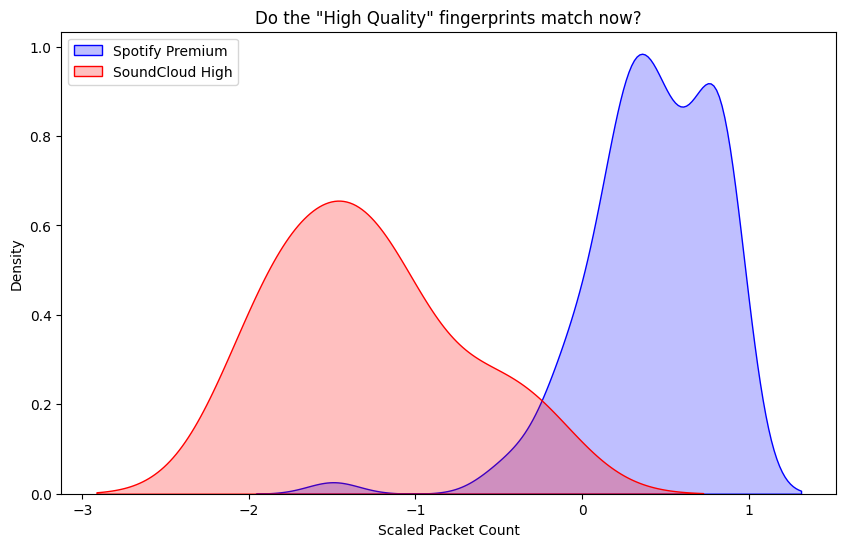

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- HELPER FUNCTION: CAP OUTLIERS ---
def cap_outliers(df, cols, percentile=0.90):
    """
    Chops off the top 10% of extreme values (like Ads) 
    so they don't ruin the math for everyone else.
    """
    df_clean = df.copy()
    for col in cols:
        limit = df_clean[col].quantile(percentile)
        # Force anything above the limit down to the limit
        df_clean[col] = np.where(df_clean[col] > limit, limit, df_clean[col])
    return df_clean

# --- 1. PREPARE DATA ---
# (Assuming df_spotify and df_sc are already loaded from your previous cell)
# If not, reload them using the 'get_dataset' function from before.

feature_cols = ['throughput_kbps', 'packet_count', 'avg_packet_size', 'avg_inter_arrival_time']

# CAP OUTLIERS (Crucial Step!)
print("Capping outliers (removing Ad spikes)...")
df_spotify_capped = cap_outliers(df_spotify, feature_cols)
df_sc_capped = cap_outliers(df_sc, feature_cols)

# --- 2. TRAIN ROBUST MODEL ---
print("Training Robust Normalized Model...")

# Use RobustScaler (Uses Median instead of Mean - better for noisy data)
scaler = RobustScaler()

# Fit scaler on Spotify, transform both
X_spotify_robust = scaler.fit_transform(df_spotify_capped[feature_cols])
X_sc_robust = scaler.transform(df_sc_capped[feature_cols])

y_spotify = df_spotify_capped['label']
y_sc = df_sc_capped['label']

# Train Brain
robust_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
robust_rf.fit(X_spotify_robust, y_spotify)

# --- 3. TEST ON SOUNDCLOUD ---
y_pred_robust = robust_rf.predict(X_sc_robust)
acc_robust = accuracy_score(y_sc, y_pred_robust)

print(f"\nRobust Model Accuracy: {acc_robust*100:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_sc, y_pred_robust))
print("\nClassification Report:")
print(classification_report(y_sc, y_pred_robust, target_names=['Low', 'High']))

# --- 4. DEBUGGING PLOT ---
# Let's see if the Capping + Robust Scaling made the distributions look similar
plt.figure(figsize=(10, 6))
# Create temporary DF for plotting
plot_df_spot = pd.DataFrame(X_spotify_robust, columns=feature_cols)
plot_df_spot['label'] = y_spotify.values
plot_df_spot['platform'] = 'Spotify'

plot_df_sc = pd.DataFrame(X_sc_robust, columns=feature_cols)
plot_df_sc['label'] = y_sc.values
plot_df_sc['platform'] = 'SoundCloud'

# Plot just the Packet Count (Scaled)
sns.kdeplot(data=plot_df_spot[plot_df_spot['label']==1], x='packet_count', fill=True, color='blue', label='Spotify Premium')
sns.kdeplot(data=plot_df_sc[plot_df_sc['label']==1], x='packet_count', fill=True, color='red', label='SoundCloud High')

plt.title('Do the "High Quality" fingerprints match now?')
plt.xlabel('Scaled Packet Count')
plt.legend()
plt.show()

In [ ]:
## Experiment D: Native SoundCloud Modeling
Since transfer learning yielded suboptimal results due to fundamental protocol differences (e.g., ad injection in Free tiers), we trained a platform-specific model using only SoundCloud data.

Given the smaller sample size for the SoundCloud dataset, we employed **5-Fold Cross-Validation**. This technique rotates the training and testing splits to ensure the accuracy metric is statistically significant and not a result of overfitting to a specific subset of data.


🧪 EXPERIMENT C: Training Native SoundCloud Model
📊 Accuracy per run: [0.5  0.5  1.   0.25 1.  ]
🏆 Average Accuracy: 65.00%

(Single Split Validation)
              precision    recall  f1-score   support

         Low       0.67      0.50      0.57         4
        High       0.33      0.50      0.40         2

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.56      0.50      0.51         6



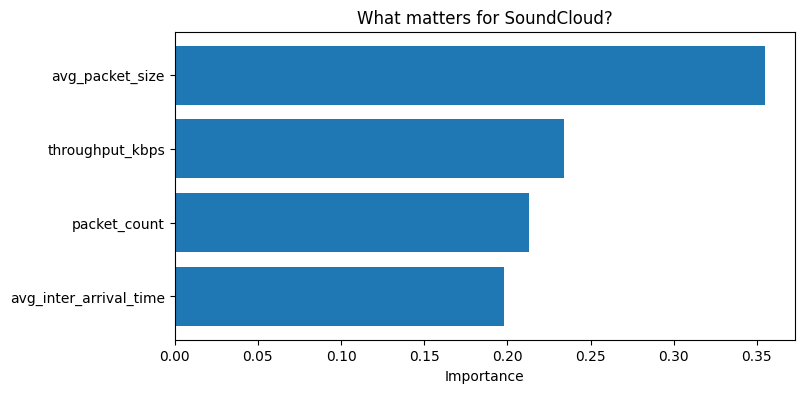

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

print("\n" + "="*40)
print("EXPERIMENT: Training Native SoundCloud Model")
print("="*40)

# Use the Capped SoundCloud data from the previous step
X_sc = df_sc_capped[feature_cols]
y_sc = df_sc_capped['label']

# Since we only have 20 samples, a simple split is risky (too small).
# We use "Cross Validation" (5-Fold). 
# It trains on 16, tests on 4... and repeats this 5 times to get an average.
sc_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Run 5-Fold Cross Validation
scores = cross_val_score(sc_clf, X_sc, y_sc, cv=5)

print(f"Accuracy per run: {scores}")
print(f"Average Accuracy: {scores.mean()*100:.2f}%")

# Let's train one final time on 80% just to see the feature importance
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sc, y_sc, test_size=0.3, random_state=42)
sc_clf.fit(X_train, y_train)
y_pred = sc_clf.predict(X_test)

print("\n(Single Split Validation)")
print(classification_report(y_test, y_pred, target_names=['Low', 'High']))

# Feature Importance for SoundCloud
importances = sc_clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8, 4))
plt.title('What matters for SoundCloud?')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel('Importance')
plt.show()